In [1]:
from typing import TypedDict, Annotated, List, Dict
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver

# env 및 langsmith


In [2]:
from dotenv import load_dotenv
from langsmith import Client

load_dotenv()
client = Client()

# 상태정의

In [3]:
class RealEstateState(TypedDict): # 그래프의 상태를 정의하는 클래스
    real_estate_type: Annotated[str ,"부동산 유형 (예: 아파트, 상가)"]
    keywordlist: Annotated[list ,"키워드 리스트"]
    messages: Annotated[list, add_messages]
    query: Annotated[str ,"생성된 SQL 쿼리"]
    results: Annotated[List[Dict], "쿼리 결과"]

In [4]:
from langgraph.graph import StateGraph, START, END
from langchain.prompts import PromptTemplate
from langchain_openai.chat_models.base import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage

# Step 1: LLM 초기화
llm = ChatOpenAI(model="gpt-4o", temperature=0.5)

# Step 2: StateGraph 정의
workflow = StateGraph(RealEstateState)

# Step 3: 노드 정의
## 필터링 노드
def filter_node(state: RealEstateState) -> RealEstateState:
    system_prompt = """
    You are an expert in real estate. Your task is to classify user questions into one of the following categories based on the provided rules:

    ### Rules:
    1. If the question is unrelated to real estate, return 'None'.
    2. If the question is about buying or selling real estate, return '매매'.
    3. If the question is about renting or leasing real estate (e.g., 전세 or 월세), return '전월세'.

    ### Output Format:
    Always respond with exactly one of the following:
    - 'None'
    - '매매'
    - '전월세'

    ### Examples:
    - '서울 아파트 매매 가격이 어떻게 되나요?' → '매매'
    - '이 동네 전세 시세 알려주세요' → '전월세'
    - '서울에서 월세 계약 조건이 어떻게 되나요?' → '전월세'
    - '이 음식점이 맛있나요?' → 'None'
    - '서울 전세 보증금은 얼마인가요?' → '전월세'
    - '서울시 부동산 매물 추천좀' → '매매'

    ### User Question:
    The user will provide a question. Use the rules above to classify the question and provide the appropriate response in the specified format. Respond only with 'None', '매매', or '전월세'. Do not provide any additional explanation or text.
    """

    response = llm.invoke([
        SystemMessage(content=system_prompt),
        HumanMessage(content=state['messages'][-1].content)
    ])

    real_estate_type = response.content.strip()


    return RealEstateState(real_estate_type=real_estate_type)

def re_questions(state: RealEstateState) -> RealEstateState:
    print("=================================")
    print("[re_questions] 질문이 부동산 관련이 아니거나 제대로 인식되지 않았습니다.")
    new_question = input("새로운 부동산 질문을 입력해주세요: ")
    print("=================================")
    # 수정된 질문을 state에 업데이트
    return RealEstateState(messages=new_question)

def fiter_router(state: RealEstateState):
    # This is the router
    real_estate_type = state["real_estate_type"]
    if real_estate_type == "매매":
        return "매매"
    elif real_estate_type == "전월세":
        return "전월세"
    else:
        return 'None'

In [5]:
workflow.add_node("Filter Question", filter_node)
workflow.add_node('Re_Questions', re_questions)

In [6]:
from IPython.display import Image, display

# 조건부 엣지 추가
workflow.add_conditional_edges(
    "Filter Question",
    fiter_router,
    { 'None': "Re_Questions", '매매': END, '전월세': END}
)

# START에서 'Filter Question' 노드로 엣지 추가
workflow.add_edge(START, "Filter Question")
workflow.add_edge("Re_Questions", "Filter Question")
workflow.add_edge("Filter Question", END)

# 그래프 컴파일
app = workflow.compile()

# 그래프 실행


[re_questions] 질문이 부동산 관련이 아니거나 제대로 인식되지 않았습니다.
[re_questions] 질문이 부동산 관련이 아니거나 제대로 인식되지 않았습니다.
[re_questions] 질문이 부동산 관련이 아니거나 제대로 인식되지 않았습니다.
[re_questions] 질문이 부동산 관련이 아니거나 제대로 인식되지 않았습니다.
{'real_estate_type': '매매', 'messages': [HumanMessage(content='부동산', additional_kwargs={}, response_metadata={}, id='72af7f2f-b0ac-4982-9448-9327263841ca'), HumanMessage(content='부부ㅜㅂ동산', additional_kwargs={}, response_metadata={}, id='503b2090-4b46-4151-a22b-d99d9d829be0'), HumanMessage(content='서울시 전세 매매', additional_kwargs={}, response_metadata={}, id='03245bcc-a374-42e2-bcd3-515e612152f2'), HumanMessage(content='아니', additional_kwargs={}, response_metadata={}, id='a0c1fe52-212a-48e0-8641-f1df49a35edf'), HumanMessage(content='서울시 저렴한 부동산', additional_kwargs={}, response_metadata={}, id='565d76bd-af31-4f16-8a2f-4c419cb42fdf')]}


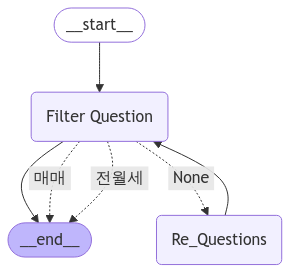

In [7]:
result = app.invoke({'messages':input()})
print(result)

workflow_image = app.get_graph().draw_mermaid_png()
display(Image(workflow_image))

In [66]:
llm = ChatOpenAI(model="gpt-4o", temperature=0.3)

In [67]:
def filter_node(user_input: str) :
    system_prompt = """
    Classify if a given question is related to real estate. If the question is related, return 'True'. If it's not related, return 'False'.

# Output Format

- Return 'Pass' if the question is real estate-related, otherwise return 'fail'.

# Examples

- 입력: '서울 아파트 매매 가격이 어떻게 되나요?'
  출력: 'Pass'

- 입력: '이 동네 전세 시세 알려주세요'
  출력: 'Pass'

- 입력: '서울에서 월세 계약 조건이 어떻게 되나요?'
  출력: 'Pass'

- 입력: '이 음식점이 맛있나요?'
  출력: 'fail'

- 입력: '서울 전세 보증금은 얼마인가요?'
  출력: 'Pass'
    """

    response = llm.invoke([
        SystemMessage(content=system_prompt),
        HumanMessage(user_input)
    ])

    real_estate_type = response.content.strip()


    return real_estate_type

In [63]:
def test_filter_node():
    test_cases = [
        ("서울 아파트 매매 가격이 어떻게 되나요?", True),
        ("이 동네 전세 시세 알려주세요", True),
        ("이 음식점이 맛있나요?", False),
        ("송파구에서 월세가 제일 저렴한 투룸을 찾아줄래?", True),
        ("회사까지 버스로 환승 없이 30분 내로 도착할 수 있으면서 주위 편의시설이 좋은 신축 오피스텔을 찾아줘", True),
        ("송파구에서 월세가 중위값인 원룸을 찾아줘", True),
        ("학교 앞 가장 싼 원룸 소개시켜줄래?", True),
        ("풀옵션에 깨끗한 신축 오피스텔 찾아줘.", True),
        ("대치동에서 버스정류장과 지하철이 가장 가까운 곳으로 알려줘", True),
        ("부평에 복층 아닌 방 좀 알아봐줘", True),
        ("강남구에 역에서 가까운 가성비 원룸 추천해줘.", True),
        ("강남까지 대중교통으로 30분 거리에 있는 신축 투룸 찾아줘", True),
        ("송파구에서 5000/40으로 구할수있는 20평대 원룸 찾아줘", True),
        ("위반 건축물, 등기 깨끗한 집을 찾아줘", False),
        ("목동에서 지하철역 도보 5분이내에 있는 투룸 이상인 집 보여줘 말만 투룸이 아니라 평수가 10평 이상이였으면 좋겠어", True),
        ("동작구에서 전세 8천 이하에 6평 이상이고 근처에 버스정류장이나 지하철 역이 있는 곳을 찾아줘", True),
        ("경기도, 지하철역이 가깝고 근처에 마트가 있는 집 추천해줘.", True),
        ("지하철/가격", False),
        ("청년전세대출이 가능한 가격대의 원룸 찾아줘", True),
        ("독산역 역세권이고, 1인 가구를 위한 원룸 오피스텔을 찾아줘.", True),
        ("강남까지 30분 이내로 갈 수 있는 교통이 편리한 원룸 찾아줘", True),
        ("지하철에서 걸어서 5~10분 거리에 있는 동작구 원룸 추천해줘", True),
        ("고양시의 분리형원룸 중 10평이상인 곳을 찾아줄래? 보증금은 1000만원 이하였으면 좋겠어. 가능하다면 근처 100m이내에 지하철역이 있는 곳으로 부탁해", True),
        ("지하철이 가깝고 비교적 저렴한 오피스텔을 추천해줘", True),
        ("10분이내로 대중교통 이용이 가능한 매물을 찾아줘", True),
        ("내가 출근할곳에서 가장 가까운 전철역하고", False),
        ("직통 전철역 두 옵션중 저렴한 집 알려줘", True),
        ("서초구 서초동 내에서 40년이상된 빌라가 50가구 이상 모여있는 구역 알려줘.", False),
        ("근처 지하철까지 도보로 10분 거리 이내의 10평 이상인 집 목록을 나열해 줘", True),
        ("인천광역시에서 고속도로랑 가깝고 주변에 큰 시장이 있는 20평대 투룸 빌라 찾아줘", True),
        ("경기권에서 20대 사회초년생 기준으로 매매가 가능한 아파트들을 추천해줘", True),
        ("주차장 있는집 추천해줘", False),
        ("서울이나 서울에 30분 이내로 왔다 갔다 할 수 있는 저렴하고 좋은 집을 알고 싶어", True),
        ("준공 5년 이내거나 리모델링한 1.5룸 찾아줘", True),
        ("전세 2억원 이하 투룸 찾아줘", True),
        ("양재역까지 도어투도어가 30분 걸리고, 전세가 4억 이하하면서 전용면적 59m^2 인 아파트 추천해줘", True),
        ("양재에서 가까운 지역의 원룸 추천해줘.", True),
        ("야탑역과 가까우면서 7평 이상의 원룸 추천해줘", True),
        ("월세 범위 이만큼에서의 방을 찾아줘", True),
        ("서울교대 근처 HUG 대출이 가능한 자취방 찾아줘", True),
        ("예산이 000인데 주변에 치안이 좋은 원룸을 찾아줘", True),
        ("여자 혼자 살기 좋은 곳 추천해줘", True),
        ("가디에서 걸어서 5분 거리의 월세가 30만원 이내, 보증금이 100만원 이내인 원룸을 추천해줘. 단, 사기의 위험성이 높은 집은 제외해줘.", True),
        ("법적으로 안전한 금천구 빌라랄 찾아줘.", True),
        ("주변에 공원이나 헬스장이 근처에 있고 채광이랑 단열이 잘 되는 집 찾아줘", True),
        ("지하철역 가까운 전세 2억 정도 오피스텔 찾아줄래", True),
        ("집이 오래되어도 상관없는데 깔끔하게 리모델링 된 집이면 좋겠어. 교통이나 치안도 좋으면 좋고. 지역은 서울 용산구쪽이 좋아. 벌레나오는 집은 싫어", True),
        ("보증보험 가능하고 hug대출 가능한 원룸 추천해줘. 내가 가진 예산은 2000만원이야", True),
        ("월세 50만원으로 구할 수 있는 광진구의 부동산 정보에 대해 알려주고, 주변에 뭐가 있는 지도 알려줘", True),
        ("내 예산은 이정도인데 서울 어디든지 역근처 도보 20분정도의 빌라를 찾아줘", True),
        ("잠실역 근처의 전세인 원룸 추천해줘", True),
        ("내 예산은 2천만원이고 은행에서 청년버팀목전세대출을 받아서 전세로 입주하려고 해 위치는 지하철 5호선 6호선 등으로 환승할 수 있는 지역이면 좋을 것 같고 방은 두개면 좋을것같고 지하철역에서 5분안에 도착할 수 있는 위치의 방을 추천해줘", True),
        ("서울 근교 5억 미만 신혼집 추천해주고 금액대 알려줘", True),
        ("역 접근성이 편한 원룸을 찾아줄래?", True),
        ("수도권 지하철역 주변 근방 500미터 이내에 평당 시세가 가장 저렴한곳 알려줘", True),
        ("강남구에서 월세가 가장저렴한 원룸에 에어컨, 냉장고, 세탁기, 건조기, 인덕션, 공기청정기, TV 옵션이 들어가 있고, 지하철 도보 10분 이내 매물.", True),
        ("교통이 편리하고 저렴한 원룸 추천해줘", True),
        ("구로구에서 분리형 원룸이면서 보증금이 500, 월세가 30정도 되는 매물만 보여줘", True),
        ("독산역 평균 시세보다 저렴한 독산역 투룸을 모두 알려주세요. 지하철역이랑 가까울수록 추천 가산점을 부여해주세요.", True),
        ("주방이 좁지않은 10평대 분리형 원룸 찾아줘", True),
        ("~역에서 최대 1회 환승해서 20분 내외로 걸리는 지하철역 부근의 10평 이하, 전세 2억 이하의 전세집을 찾아줘.", True),
        ("3년이내 지어진 집 추천해줘", True),
        ("내가 계약을 했을 때 문제가 안될만한 매물이 있을까?", False),
        ("2호선 라인에서 저렴한 신축 오피스텔을 찾아줘 건조기도 있고 스타일러도 있아야해", True),
        ("풀옵션인 전세집으로 추천해줘.", True),
        ("성북구에서 2호선이랑 제일 가깝거나 환승하기 쉬운 원룸, 오피스텔 찾아줘", True),
    ]

    error_count = 0
    errors = []

    for idx, (input_question, expected_output) in enumerate(test_cases):
        result = filter_node(input_question)
        if result != expected_output:
            error_count += 1
            errors.append((idx + 1, input_question, result, expected_output))

    print(f"Total Test Cases: {len(test_cases)}")
    print(f"Errors: {error_count}")
    if errors:
        print("Error Details:")
        for error in errors:
            print(f"Test Case {error[0]}: Input: {error[1]} | Got: {error[2]} | Expected: {error[3]}")


In [64]:
test_filter_node()


Total Test Cases: 66
Errors: 66
Error Details:
Test Case 1: Input: 서울 아파트 매매 가격이 어떻게 되나요? | Got: 'True' | Expected: True
Test Case 2: Input: 이 동네 전세 시세 알려주세요 | Got: 'True' | Expected: True
Test Case 3: Input: 이 음식점이 맛있나요? | Got: 'False' | Expected: False
Test Case 4: Input: 송파구에서 월세가 제일 저렴한 투룸을 찾아줄래? | Got: 'True' | Expected: True
Test Case 5: Input: 회사까지 버스로 환승 없이 30분 내로 도착할 수 있으면서 주위 편의시설이 좋은 신축 오피스텔을 찾아줘 | Got: 'True' | Expected: True
Test Case 6: Input: 송파구에서 월세가 중위값인 원룸을 찾아줘 | Got: 'True' | Expected: True
Test Case 7: Input: 학교 앞 가장 싼 원룸 소개시켜줄래? | Got: 'True' | Expected: True
Test Case 8: Input: 풀옵션에 깨끗한 신축 오피스텔 찾아줘. | Got: 'True' | Expected: True
Test Case 9: Input: 대치동에서 버스정류장과 지하철이 가장 가까운 곳으로 알려줘 | Got: 'False' | Expected: True
Test Case 10: Input: 부평에 복층 아닌 방 좀 알아봐줘 | Got: True | Expected: True
Test Case 11: Input: 강남구에 역에서 가까운 가성비 원룸 추천해줘. | Got: 'True' | Expected: True
Test Case 12: Input: 강남까지 대중교통으로 30분 거리에 있는 신축 투룸 찾아줘 | Got: 'True' | Expected: True
Test Case 13: Input: 송